### Source:
1) https://github.com/eitanrich/torch-mfa 

2) https://github.com/eitanrich/gans-n-gmms



### Getting: CelebA Dataset

In [1]:
!wget -q https://raw.githubusercontent.com/sayantanauddy/vae_lightning/main/data.py

### Getting helper functions 

In [2]:
!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/mfa_celeba_helpers.py

### Get the Kaggle api token and upload it to colab. Follow the instructions [here](https://github.com/Kaggle/kaggle-api#api-credentials).


In [3]:
!pip install kaggle

In [4]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!mkdir /root/.kaggle

In [6]:
!cp kaggle.json /root/.kaggle/kaggle.json

In [7]:
!chmod 600 /root/.kaggle/kaggle.json

### Train and saving the checkpoint

In [8]:
!pip install torchvision

In [9]:
!pip install pytorch-lightning

     |████████████████████████████████| 915 kB 9.3 MB/s 
     |████████████████████████████████| 10.6 MB 57.8 MB/s 
     |████████████████████████████████| 118 kB 56.2 MB/s 
     |████████████████████████████████| 829 kB 50.8 MB/s 
     |████████████████████████████████| 636 kB 55.9 MB/s 
     |████████████████████████████████| 234 kB 65.0 MB/s 
     |████████████████████████████████| 1.3 MB 50.8 MB/s 
     |████████████████████████████████| 142 kB 74.1 MB/s 
     |████████████████████████████████| 294 kB 60.1 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=6b8f7d5812f120bbde2518947439a9de2f7af615d60c0b95913b271cfa684b33
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Attempting uninstal

Preparing dataset and parameters for celeba ...


  0%|          | 5.00M/1.33G [00:00<00:43, 32.4MB/s]

100%|██████████| 1.33G/1.33G [00:13<00:00, 103MB/s]


100%|██████████| 2.02M/2.02M [00:00<00:00, 143MB/s]


100%|██████████| 1.54M/1.54M [00:00<00:00, 187MB/s]


100%|██████████| 466k/466k [00:00<00:00, 196MB/s]


100%|██████████| 2.07M/2.07M [00:00<00:00, 196MB/s]


Done!



/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


Files exist already
Defining the MFA model...
EM fitting: 300 components / 10 factors / batch size 1000 ...
Random init using rnd_samples with 22 samples per component...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteration 0/30, log-likelihood=4835.4833984375:
EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE / M... (181.7995638847351 sec)
Iteration 1/30, log-likelihood=8939.986328125:
EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE / M... (176.71581649780273 sec)
Iteration 2/30, log-likelihood=9226.72265625:
EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE / M... (175.97505497932434 sec)
Iteration 3/30, log-likelihood=9342.8369140625:
EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE / M... (176.88865876197815 sec)
Iteration 4/30, log-likeliho

Visualizing the trained model...
Generating random samples...


Plotting test log-likelihood graph...
Done


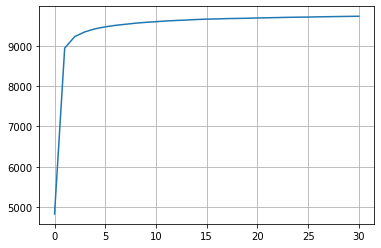

In [10]:
import sys, os
import torch
from torchvision.datasets import CelebA, MNIST
import torchvision.transforms as transforms
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from torch.utils.data import DataLoader, random_split
import numpy as np
from matplotlib import pyplot as plt
from imageio import imwrite
from packaging import version
from mfa_celeba_helpers import *
from data import CelebADataset, CelebADataModule

"""
MFA model training (data fitting) example.
Note that actual EM (and SGD) training code are part of the MFA class itself.
"""


def main(argv):
    assert version.parse(torch.__version__) >= version.parse("1.2.0")

    dataset = argv[1] if len(argv) == 2 else "celeba"
    print("Preparing dataset and parameters for", dataset, "...")

    if dataset == "celeba":
        image_shape = [64, 64, 3]  # The input image shape
        n_components = 300  # Number of components in the mixture model
        n_factors = 10  # Number of factors - the latent dimension (same for all components)
        batch_size = 1000  # The EM batch size
        num_iterations = 30  # Number of EM iterations (=epochs)
        feature_sampling = 0.2  # For faster responsibilities calculation, randomly sample the coordinates (or False)
        mfa_sgd_epochs = 0  # Perform additional training with diagonal (per-pixel) covariance, using SGD
        init_method = "rnd_samples"  # Initialize each component from few random samples using PPCA
        trans = transforms.Compose(
            [
                CropTransform((25, 50, 25 + 128, 50 + 128)),
                transforms.Resize(image_shape[0]),
                transforms.ToTensor(),
                ReshapeTransform([-1]),
            ]
        )
        train_set = CelebADataset(root="./data", split="train", transform=trans, download=True)
        test_set = CelebADataset(root="./data", split="test", transform=trans, download=True)
    elif dataset == "mnist":
        image_shape = [28, 28]  # The input image shape
        n_components = 50  # Number of components in the mixture model
        n_factors = 6  # Number of factors - the latent dimension (same for all components)
        batch_size = 1000  # The EM batch size
        num_iterations = 30  # Number of EM iterations (=epochs)
        feature_sampling = False  # For faster responsibilities calculation, randomly sample the coordinates (or False)
        mfa_sgd_epochs = 0  # Perform additional training with diagonal (per-pixel) covariance, using SGD
        init_method = "kmeans"  # Initialize by using k-means clustering
        trans = transforms.Compose([transforms.ToTensor(), ReshapeTransform([-1])])
        train_set = MNIST(root="./data", train=True, transform=trans, download=True)
        test_set = MNIST(root="./data", train=False, transform=trans, download=True)
    else:
        assert False, "Unknown dataset: " + dataset

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model_dir = "./models/" + dataset
    os.makedirs(model_dir, exist_ok=True)
    figures_dir = "./figures/" + dataset
    os.makedirs(figures_dir, exist_ok=True)
    model_name = "c_{}_l_{}_init_{}".format(n_components, n_factors, init_method)

    print("Defining the MFA model...")
    model = MFA(
        n_components=n_components, n_features=np.prod(image_shape), n_factors=n_factors, init_method=init_method
    ).to(device=device)

    print("EM fitting: {} components / {} factors / batch size {} ...".format(n_components, n_factors, batch_size))
    ll_log = model.batch_fit(
        train_set, test_set, batch_size=batch_size, max_iterations=num_iterations, feature_sampling=feature_sampling
    )

    if mfa_sgd_epochs > 0:
        print("Continuing training using SGD with diagonal (instead of isotropic) noise covariance...")
        model.isotropic_noise = False
        ll_log_sgd = model.sgd_mfa_train(
            train_set, test_size=256, max_epochs=mfa_sgd_epochs, feature_sampling=feature_sampling
        )
        ll_log += ll_log_sgd

    print("Saving the model...")
    torch.save(model.state_dict(), os.path.join(model_dir, "model_" + model_name + ".pth"))

    print("Visualizing the trained model...")
    model_image = visualize_model(model, image_shape=image_shape, end_component=10)
    imwrite(os.path.join(figures_dir, "model_" + model_name + ".jpg"), model_image)

    print("Generating random samples...")
    rnd_samples, _ = model.sample(100, with_noise=False)
    mosaic = samples_to_mosaic(rnd_samples, image_shape=image_shape)
    imwrite(os.path.join(figures_dir, "samples_" + model_name + ".jpg"), mosaic)

    print("Plotting test log-likelihood graph...")
    plt.plot(ll_log, label="c{}_l{}_b{}".format(n_components, n_factors, batch_size))
    plt.grid(True)
    plt.savefig(os.path.join(figures_dir, "training_graph_" + model_name + ".jpg"))
    print("Done")


if __name__ == "__main__":
    main(sys.argv)